# StyleGAN3 Editing

- Pixel2Style2Pixel (pSp)
- Encoder4Editing (e4e)

https://github.com/yuval-alaluf/stylegan3-editing

In [ ]:
!wget -q https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat -O content/models/shape_predictor_68_face_landmarks.dat
# https://drive.google.com/file/d/12WZi2a9ORVg-j6d9x4eF-CKpLaURC2W-/view

In [1]:
import sys
import pprint
import numpy as np
from PIL import Image
import dataclasses
import torch
import torchvision.transforms as transforms
import dlib

sys.path.insert(0, "stylegan3-editing")

from utils.common import tensor2im
from utils.inference_utils import run_on_batch, load_encoder, get_average_image
from utils.alignment_utils import align_face

## Load pSp model

In [2]:
encoder, opts = load_encoder(checkpoint_path='content/models/restyle_pSp_ffhq.pt')

pprint.pprint(dataclasses.asdict(opts))

Loading ReStyle pSp from checkpoint: content/models/restyle_pSp_ffhq.pt
Loading StyleGAN3 generator from path: None
Done!
Model successfully loaded!
{'batch_size': 2,
 'board_interval': 50,
 'checkpoint_path': 'content/models/restyle_pSp_ffhq.pt',
 'dataset_type': 'ffhq_encode',
 'device': None,
 'encoder_type': 'BackboneEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 6,
 'l2_lambda': 1.0,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'max_steps': 500000,
 'max_val_batches': 150,
 'moco_lambda': 0,
 'n_iters_per_batch': 3,
 'optim_name': 'ranger',
 'output_size': 1024,
 'save_interval': 10000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 2,
 'test_workers': 8,
 'train_decoder': False,
 'val_interval': 5000,
 'w_norm_lambda': 0.0,
 'workers': 8}


## Prepare the input image

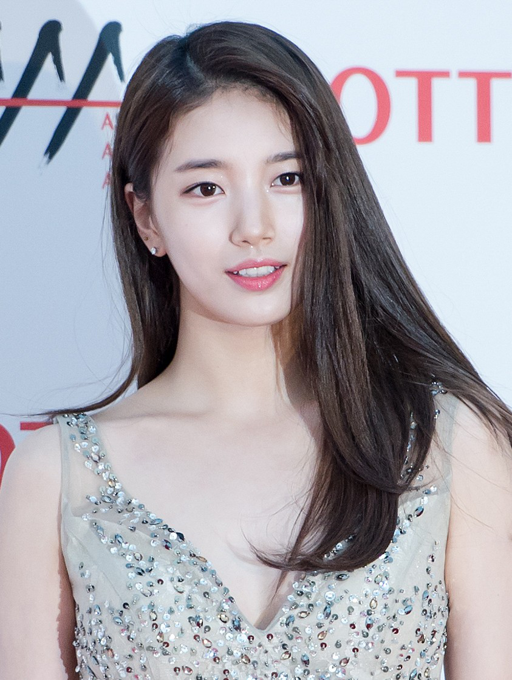

In [10]:
from PIL import Image

img_path = 'content/suzy.jpg'

img = Image.open(img_path)

img.resize((512, 680))

## Align and crop face

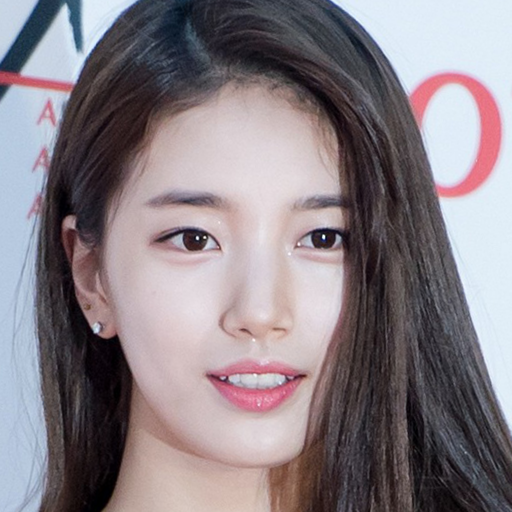

In [11]:
aligned_img = align_face(
    filepath=img_path,
    detector=dlib.get_frontal_face_detector(),
    predictor=dlib.shape_predictor('content/models/shape_predictor_68_face_landmarks.dat'))

aligned_img.resize((512, 512))

## Preprocess

In [12]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

inputs = transform(aligned_img)
inputs = inputs.unsqueeze(0).to('cuda').float()

print(inputs.shape)

torch.Size([1, 3, 256, 256])


## pSp encoder

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


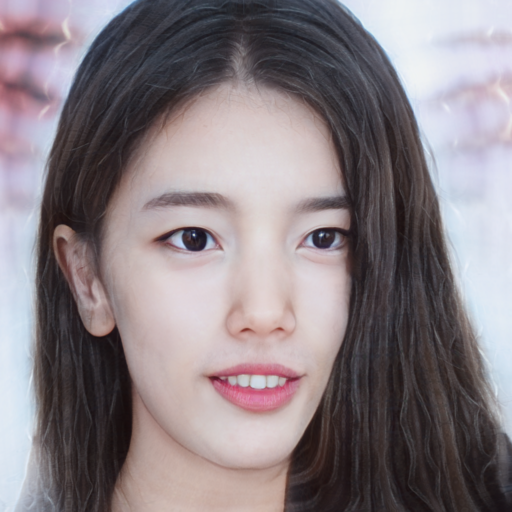

In [13]:
opts.n_iters_per_batch = 3
opts.resize_outputs = False  # generate outputs at full resolution

avg_image = get_average_image(encoder)

with torch.no_grad():
    result_batch, result_latents = run_on_batch(
        inputs=inputs,
        net=encoder,
        opts=opts,
        avg_image=avg_image,
        landmarks_transform=None)

tensor2im(result_batch[0][-1]).resize((512, 512))

In [14]:
latent = np.expand_dims(result_latents[0][-1], axis=0)
latent = torch.from_numpy(latent).to('cuda').float()

print(latent.shape)

torch.Size([1, 16, 512])


## Edit the input image using StyleGAN-NADA

In [16]:
sys.path.insert(0, 'ZSSGAN')
from ZSSGAN.model.ZSSGAN import SG3Generator

net = SG3Generator('content/output/Photo_Rotten Zombie/checkpoint/Photo_Rotten Zombie.pkl')

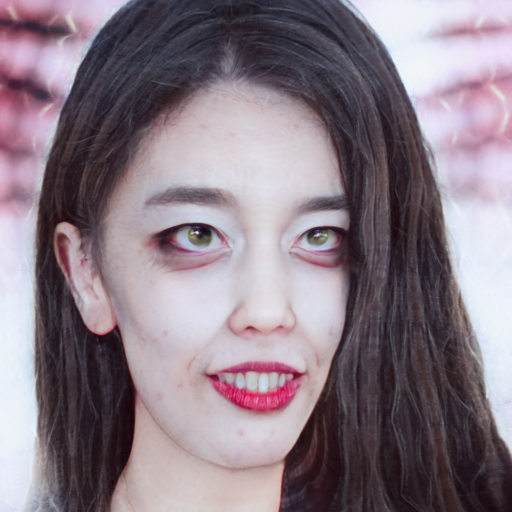

In [17]:
output = net(latent)

tensor2im(output[0].squeeze()).resize((512, 512))